In [1]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np

from scipy import signal

dr = '/Users/colinwageman/Desktop/DESKTOP/School/Cogs199/Recordings/Speller/'
file_1 = 'run_03.xdf'
file_2 = 'run_04.xdf'

# file 'run_03' contains data for spelling 'QUICK'
# file 'run_04' contains data for spelling 'P3EEG'

In [2]:
channels = ['ref', 'FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz', 'Fp1']
aux_chs = ['aux ch_1', 'aux ch_2', 'aux ch_3']

def speller_file_to_dict(data):
    run = {
        'data': [],
        'time_stamps': [],
        'aux': [],
        'aux_time_stamps': [],
        'markers': [],
        'marker_time_stamps': [],
        'sample_rate': {},
    }
    for stream in data:
        if stream['info']['name'][0] == 'eeg_data':
            run['data'] = stream['time_series']
            run['time_stamps'] = stream['time_stamps']
            run['sample_rate']['eeg'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'aux_data':
            run['aux'] = stream['time_series']
            run['aux_time_stamps'] = stream['time_stamps']
            run['sample_rate']['aux'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'P300_Speller_Markers':
            run['markers'] = stream['time_series']
            run['marker_time_stamps'] = stream['time_stamps']
        else:
            print('Warning unmatched stream name')
            
    return run

data = {
    'run': [],
}

for file_nm in [file_1, file_2]:
    imported_data, _ = pyxdf.load_xdf(dr+file_nm)
    run = speller_file_to_dict(imported_data)
    data['run'].append(run)
    
# print(data)

In [3]:
# data['run'][0]['time_stamps']

In [4]:
def filter_eeg(ch_datas, sample_rate, f_range):
    nyq = 0.5 * FREQ
    low_limit = f_range[0] / nyq
    high_limit = f_range[1] / nyq
    
    sos = signal.butter(2, [low_limit, high_limit], btype='bandpass', output='sos')
    sig_filt = signal.sosfiltfilt(sos, ch_datas, axis=0)    
    
    return np.array(sig_filt)

In [5]:
def plot_time_series(X, Y, labels, xlabel=None, ylabel=None, title=None, fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)

    for i in range(len(Y.T)):
        y = Y[:,i]
        ax.plot(X, y, label=labels[i])
        
    xlabel = xlabel if xlabel is not None else 'Time'
    ylabel = ylabel if ylabel is not None else 'Amplitude'
    title = title if title is not None else 'Time Series'
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    _ = ax.legend()
    
    return fig, ax

def add_markers_to_plot(markers, time_stamps, fig, ax):
    for timestamp, marker in zip(time_stamps, markers):
#             if (marker[0] == '1'):
            if '[' in marker[0]:
                ax.axvline(x=timestamp, color='C1')

In [6]:
run_2 = data['run'][1]
# fig, ax = plot_time_series(
#     X = run_2['aux_time_stamps'],
#     Y = run_2['aux'][:,1:2],
#     labels = aux_chs[1:2],
#     xlabel='Time (sec)',
#     ylabel=r'Amplitude ($\mu$V)',
#     title='Run 2 Photosensor'
# )
# add_markers_to_plot(run_2['markers'], run_2['marker_time_stamps'], fig, ax)

### Scale Photosensor
During the first run the screen brightness wasn't as it's brightest. Here I scale it up so as to use the same threshold for each.

In [7]:
max_run1 = max(data['run'][0]['aux'][:,1])
max_run2 = max(data['run'][1]['aux'][:,1])
scaler = max_run2/max_run1
data['run'][0]['aux'][:,1] = data['run'][0]['aux'][:,1] * scaler

In [8]:
run_1 = data['run'][0]
# fig, ax = plot_time_series(
#     X = run_1['aux_time_stamps'],
#     Y = run_1['aux'][:,1:2],
#     labels = aux_chs[1:2],
#     xlabel='Time (sec)',
#     ylabel=r'Amplitude ($\mu$V)',
#     title='Run 1 Photosensor'
# )
# add_markers_to_plot(run_1['markers'], run_1['marker_time_stamps'], fig, ax)

In [9]:
def get_samples_for_t_range(time_series, time_stamps, t_range, inclusive=False):
    if inclusive:
        low_filt = time_stamps >= t_range[0]
    else:
        low_filt = time_stamps > t_range[0]
        
    high_filt = time_stamps < t_range[1]
    index_range = low_filt == high_filt
    data_range = time_series[index_range]
    ts_range = time_stamps[index_range]
    return data_range, ts_range

In [10]:
# Filtering in Hz
FREQ = 250.0 # sample rate
LOWCUT = 0.1
HIGHCUT = 15.0

freq_range = [LOWCUT,HIGHCUT]
eeg_filtered = filter_eeg(run_1['data'], FREQ, freq_range)
eeg_ts = run_1['time_stamps']
# eeg_filtered = eeg_filtered.T
# eeg_filtered.shape

# Epoch durations in sec
PRE_STIM = 0.250
POST_STIM = 0.800
PS_THRESHOLD = 70

answer_key = {
    'Q': [3, 11],
    'U': [4, 9],
    'I': [2, 9],
    'C': [1, 9],
    'K': [2, 11],
    'P': [3, 10],
    '3': [5, 11],
    'E': [1, 11],
    'G': [2, 7],    
}
letter_ts = []
group_labels = []
for i, marker in enumerate(run_1['markers']):
#     print(marker)
    if '[' in marker[0]:
        lbl = marker[0].split('[')[1].split(']')[0]
        group_labels.append(lbl)
        letter_ts.append(run_1['marker_time_stamps'][i])
        
print(run_1['marker_time_stamps'][i], run_1['aux_time_stamps'][-1])

# don't forget the last letter
letter_ts.append(run_1['aux_time_stamps'][-1])
print(group_labels)
print(letter_ts)
sp_markers = []
aux_for_sp_markers = []
for i in range(1, len(letter_ts)):
    t_range = [letter_ts[i-1],letter_ts[i]]
    dr, dr_ts = get_samples_for_t_range(np.array(run_1['markers']), run_1['marker_time_stamps'], t_range)
    a_tup = get_samples_for_t_range(run_1['aux'], run_1['aux_time_stamps'], t_range)
    sp_markers.append(dr)
    aux_for_sp_markers.append(a_tup)

sp_markers = np.array(sp_markers).reshape((5,120))
# print(sp_markers)

# Convert AUX Data to binary 1 at the start of stim
onset_ts = []
for aux_set_data, aux_set_ts in aux_for_sp_markers:
    ltr_group = []
    for i in range(1,len(aux_set_data)):
        val = int(aux_set_data[i,1] >= PS_THRESHOLD)
        prev = int(aux_set_data[i-1,1] >= PS_THRESHOLD)
        t = aux_set_ts[i]
        if (val-prev == 1):
            ltr_group.append(t)
            
    onset_ts.append(ltr_group)

onset_ts = np.array(onset_ts)
# stim_labels = np.array(marker_data).flatten()
# print('Number of stimuli match number of markers:', len(onset_ts) == len(stim_labels))

target_stim_epochs = []
non_target_stim_epochs = []
target_stim_ps_epochs = []
non_target_stim_ps_epochs = []

for onsets, labels, key in zip(onset_ts, sp_markers, group_labels):
    for ts, label in zip(onsets, labels):
        epoch_start = ts - PRE_STIM
        epoch_end = ts + POST_STIM
    #     print(epoch_start, epoch_end)
        # exclude raw ref channel at index 0
        epoch_tuple = get_samples_for_t_range(eeg_filtered, eeg_ts, [epoch_start, epoch_end])
        sensor_tuple = get_samples_for_t_range(run_1['aux'][:,1], run_1['aux_time_stamps'], [epoch_start, epoch_end+.004])
        
        ans = answer_key[key]
#         print(key, ans)
        if int(label) in ans:
            target_stim_epochs.append(epoch_tuple)
            target_stim_ps_epochs.append(sensor_tuple)
        else:
            non_target_stim_epochs.append(epoch_tuple)
            non_target_stim_ps_epochs.append(sensor_tuple)

print(f'{len(non_target_stim_epochs)} Non-Target Epochs and {len(target_stim_epochs)} Target Epochs')

1655.3626382826808 1669.5259665445276
['Q', 'U', 'I', 'C', 'K']
[1430.3499513482054, 1476.03514164977, 1521.554616875919, 1567.0840907582742, 1612.6285559889382, 1669.5259665445276]
500 Non-Target Epochs and 100 Target Epochs


In [11]:
def ms_to_samples(duration, rate=250):
    return round((duration/1000.0) * 250.0)

def baseline_center(eeg_event_ch, baseline_duration):
    baseline_samples = ms_to_samples(baseline_duration)
    base_avg = np.mean(eeg_event_ch[0:baseline_samples])
    baseline_centered = eeg_event_ch - base_avg
    return baseline_centered

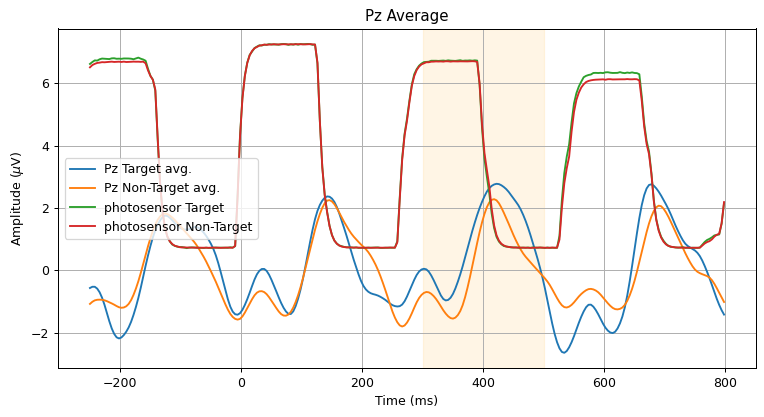

In [12]:
# channels = ['ref', 'FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz', 'Fp1']
chan_index = 4
ch_label = channels[chan_index]

test_x = [(i*4)-250 for i in range(len(target_stim_epochs[0][0]))]

Pz_odd_epochs = []
Pz_std_epochs = []
for eeg_event_data, eeg_event_ts in target_stim_epochs:
    b = baseline_center(eeg_event_data[:,chan_index], PRE_STIM*1000)
    Pz_odd_epochs.append(b)
    
for eeg_event_data, eeg_event_ts in non_target_stim_epochs:
    b = baseline_center(eeg_event_data[:,chan_index], PRE_STIM*1000)
    Pz_std_epochs.append(b)
        
Pz_odd_epochs = np.array(Pz_odd_epochs)
# print(Pz_odd_epochs.shape)
Pz_std_epochs = np.array(Pz_std_epochs)
Pz_odd_epoch_avg = np.mean(Pz_odd_epochs, axis=0)
# print(Pz_odd_epoch_avg.shape)
Pz_std_epoch_avg = np.mean(Pz_std_epochs, axis=0)
odd_stim_ps_avg = np.mean(np.array(target_stim_ps_epochs)[:,0], axis=0)
# print(odd_stim_ps_avg.shape)
std_stim_ps_avg = np.mean(np.array(non_target_stim_ps_epochs)[:,0], axis=0)

fig, ax = plt.subplots(figsize = (10, 5), dpi = 90)
ax.axvspan(300, 500, color='orange', alpha=0.1)

ax.plot(test_x, Pz_odd_epoch_avg, label=f'{ch_label} Target avg.')
ax.plot(test_x, Pz_std_epoch_avg, label=f'{ch_label} Non-Target avg.')
ax.plot(test_x, odd_stim_ps_avg*0.05, label='photosensor Target')
ax.plot(test_x, std_stim_ps_avg*0.05, label='photosensor Non-Target')

ax.set_xlabel('Time (ms)')
ax.set_ylabel(r'Amplitude ($\mu$V)')
ax.set_title(f'{ch_label} Average')
ax.grid(True)
_ = ax.legend()

In [13]:
def get_epochs(event_times, pre_stim, post_stim, rate=250):
    # split raw data based on markers and pre/post stim
    # return dataframe with sensors and marker as attributes
    pass

def split_x_from_y(epochs):
    # split the markers from the sensor data
    # return X, Y
    pass

def get_training_test_sets(epochs, percent_testing):
    # return traning df and testing df
    pass

In [14]:
print(data)

{'run': [{'data': array([[-105673.70571777,   35751.61525626,   37462.14955594, ...,
          32388.97411692,   34473.40839784,   37233.33474795],
       [-105696.59390409,   35750.34120683,   37457.00865471, ...,
          32386.73894247,   34467.52988905,   37229.87022756],
       [-105685.37332837,   35747.05550039,   37457.16511693, ...,
          32405.00031769,   34469.98858094,   37225.51163739],
       ...,
       [ -96755.9631772 ,   39976.96667635,   35866.68203672, ...,
          31614.93320643,   33907.5963387 ,   35376.19535639],
       [ -96774.38101463,   39969.52354545,   35855.32735054, ...,
          31604.561997  ,   33895.34758274,   35371.25562087],
       [ -96802.9241923 ,   39968.16008904,   35852.6451412 , ...,
          31596.29185156,   33889.60318441,   35369.5121848 ]]), 'time_stamps': array([1417.9418356 , 1417.9458356 , 1417.94983561, ..., 1669.517964  ,
       1669.521964  , 1669.525964  ]), 'aux': array([[ 417.        ,   26.7826087 , 1020.        ],
 

In [15]:
run2 = data['run'][1]
run2

{'data': array([[-85763.39760582,  35817.68701287,  29531.46005052, ...,
          26478.94936549,  29594.13434197,  28247.06175888],
        [-85795.98644924,  35804.23126271,  29515.99264336, ...,
          26469.13694967,  29576.67762955,  28234.94711339],
        [-85807.36348717,  35810.06506801,  29523.32401554, ...,
          26478.74819979,  29582.19851043,  28235.93059014],
        ...,
        [-83014.73653492,  35099.07842864,  28602.02981258, ...,
          25789.50980777,  29689.24101463,  28820.02637625],
        [-83005.72878191,  35097.22323385,  28598.14060904, ...,
          25786.84995018,  29685.28475586,  28819.42287915],
        [-83036.90946542,  35094.00458264,  28591.54684443, ...,
          25776.97047913,  29677.662811  ,  28814.68430933]]),
 'time_stamps': array([2395.29678187, 2395.30078187, 2395.30478188, ..., 2643.83286811,
        2643.83686811, 2643.84086811]),
 'aux': array([[ 417.,   14., 1020.],
        [ 417.,   14., 1018.],
        [ 416.,   14., 1

In [16]:
sensor_reading = []
for sample in run2['aux']:
    if sample[1] > 70:
        sensor_reading.append(1)
    else:
        sensor_reading.append(0)
        
count = 0
sr = []
for i, level in enumerate(sensor_reading):
    prev = sensor_reading[max(0,i-1)]
    if level > prev:
        count += 1
        sr.append(1)
    else:
        sr.append(0)
        
sensor_reading = sr
count


603

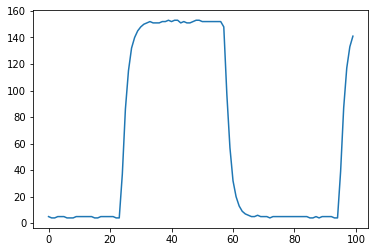

In [17]:
plt.plot(run2['aux'][5300:5400,1])

In [18]:
len(run2['markers'])

606

In [19]:
times = []
for i, (level, t_stmp) in enumerate(zip(sensor_reading, run2['aux_time_stamps'])):
    if level == 1:
        times.append(t_stmp)
        
times

[2401.8407852761607,
 2403.9127860096924,
 2404.932786370794,
 2416.5967905000975,
 2416.8807906006396,
 2417.1647907011816,
 2417.4487908017236,
 2417.7327909022656,
 2418.0167910028076,
 2418.3007911033496,
 2418.5847912038917,
 2418.8687913044337,
 2419.1527914049757,
 2419.4367915055177,
 2419.7167916046437,
 2420.484791876532,
 2420.75279197141,
 2421.0207920662874,
 2421.288792161165,
 2421.572792261707,
 2421.8367923551687,
 2422.1047924500463,
 2422.372792544924,
 2422.640792639802,
 2422.924792740344,
 2423.1887928338056,
 2423.456792928683,
 2424.2407932062356,
 2424.508793301113,
 2424.776793395991,
 2425.0407934894524,
 2425.3087935843305,
 2425.5927936848725,
 2425.86079377975,
 2426.1287938746277,
 2426.3927939680893,
 2426.660794062967,
 2426.9287941578445,
 2427.2127942583866,
 2427.980794530275,
 2428.2487946251526,
 2428.5327947256947,
 2428.7967948191563,
 2429.064794914034,
 2429.3327950089115,
 2429.600795103789,
 2429.8847952043316,
 2430.164795303457,
 2430.43279

In [20]:
# notes: markers ahead of photosensor. No photosensor for '[P]3EEG'
# first aux blink is red flash = trash
# calibration blinks are 1s apart, followed by ~12s
print(run2['markers'][:4])
print(run2['marker_time_stamps'][:4])
print(times[1:5])

[['P3EEG'], ['[P]3EEG'], ['4'], ['6']]
[2400.80030268 2409.50471681 2415.57397392 2415.85420843]
[2403.9127860096924, 2404.932786370794, 2416.5967905000975, 2416.8807906006396]


In [21]:
2416.5967905000975 - 2415.57397392

1.0228165800976967

In [22]:
# P3EEG trial collection
all_trial = []
current_key = []
runs = []
count = 3 # we want to ignore the first red aux, then the 2 calibration blinks
for marker_ar, time_stamp in zip(run2['markers'], run2['marker_time_stamps']):
    marker = marker_ar[0]        
    if '[' in marker:
        lbl = marker.split('[')[1].split(']')[0]
        current_key = answer_key[lbl]
        runs.append({'target': lbl, 'trials': []})
    elif marker.isnumeric():
        marker = int(marker)
        trial = {
            'label': marker,
            'time': times[count]
        }
        runs[-1]['trials'].append(trial)
        if marker in current_key:
            all_trial.append((times[count], 1))
        else:
            all_trial.append((times[count], 0))
            
        count += 1
    else:
        print('Trial:', marker)
        
print(all_trial[:5])
print('length:', len(all_trial))
print(runs)

Trial: P3EEG
[(2416.5967905000975, 0), (2416.8807906006396, 0), (2417.1647907011816, 0), (2417.4487908017236, 0), (2417.7327909022656, 0)]
length: 600
[{'target': 'P', 'trials': [{'label': 4, 'time': 2416.5967905000975}, {'label': 6, 'time': 2416.8807906006396}, {'label': 9, 'time': 2417.1647907011816}, {'label': 8, 'time': 2417.4487908017236}, {'label': 1, 'time': 2417.7327909022656}, {'label': 7, 'time': 2418.0167910028076}, {'label': 3, 'time': 2418.3007911033496}, {'label': 0, 'time': 2418.5847912038917}, {'label': 10, 'time': 2418.8687913044337}, {'label': 5, 'time': 2419.1527914049757}, {'label': 11, 'time': 2419.4367915055177}, {'label': 2, 'time': 2419.7167916046437}, {'label': 1, 'time': 2420.484791876532}, {'label': 7, 'time': 2420.75279197141}, {'label': 2, 'time': 2421.0207920662874}, {'label': 3, 'time': 2421.288792161165}, {'label': 6, 'time': 2421.572792261707}, {'label': 8, 'time': 2421.8367923551687}, {'label': 5, 'time': 2422.1047924500463}, {'label': 11, 'time': 2422

In [23]:
def get_epoch(data, data_times, stim_time, pre_stim_ms, post_stim_ms, sample_rate):
    ms_per_sample = 1000 / sample_rate
    
    # TODO: is there a faster way?
    i = (np.abs(data_times - stim_time)).argmin()
    start = i - int(pre_stim_ms / ms_per_sample)
    stop = i + int(post_stim_ms / ms_per_sample) + 1
    epoch = data[start:stop]
    return epoch

def subtract_baseline(epoch, baseline_duration_ms, sample_rate):
    ms_per_sample = 1000 / sample_rate
    baseline_samples = int(baseline_duration_ms / ms_per_sample)
    pre_stimulus = epoch[:baseline_samples]
    baseline = np.mean(pre_stimulus, 0)
    return epoch - baseline


# make epochs
data_time_stmps = np.array(run2['time_stamps'])
raw_pd_data = []
for (time, y) in all_trial:
    # get epoch based on time stamp
    
    epoch = get_epoch(run2['data'], data_time_stmps, time, 100, 800, 250)
    raw_pd_data.append([epoch,y])
    
# raw_pd_data

FREQ = 250.0 # sample rate
LOWCUT = 0.1
HIGHCUT = 15.0

freq_range = [LOWCUT,HIGHCUT]

for run in runs:
    for trial in run['trials']:
        epoch = get_epoch(run2['data'], data_time_stmps, trial['time'], 100, 800, 250)
        epoch_filtered = filter_eeg(epoch, FREQ, freq_range)
        trial['data'] = subtract_baseline(epoch_filtered, 100, 250)

# runs

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [25]:
channels = ['ref', 'FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz', 'Fp1']
pz = channels.index('Pz')

# Filtering in Hz
FREQ = 250.0 # sample rate
LOWCUT = 0.1
HIGHCUT = 15.0

freq_range = [LOWCUT,HIGHCUT]
# eeg_filtered = filter_eeg(run_1['data'], FREQ, freq_range)

# df[:]['epoch'][:,:,pz].shape
# epoch_array = np.array(raw_pd_data[:,0])
# epoch_array
X = []
Y = []
for row in raw_pd_data:
    X.append(filter_eeg(row[0], FREQ, freq_range))
    Y.append(row[1])

X = np.array(X)
Y = np.array(Y)
X_Pz = X[:,:,pz]

In [26]:
X_Pz_adj = []
for epoch in X_Pz:
    pre_stimulus = epoch[:25] # 250 * 0.1 sec = 25 samples
    baseline = np.mean(pre_stimulus, 0)
    baseline_adj = epoch - baseline
    X_Pz_adj.append(baseline_adj)
    
X_Pz_adj = np.array(X_Pz_adj)
X_Pz_adj

array([[-1.70753917, -1.95692816, -2.10499819, ...,  0.86432637,
         4.14807902,  7.8984325 ],
       [13.22883645, 10.41563492,  7.53653566, ..., 16.05014957,
        18.0977084 , 20.18758567],
       [20.90227024, 12.47255759,  4.84393169, ..., 19.12343108,
        21.65223832, 24.55283452],
       ...,
       [ 0.36126603,  1.92922457,  3.3398691 , ..., -2.18761568,
         0.02799659,  2.55661582],
       [ 4.37154278,  1.699497  , -0.40975399, ..., 13.96364451,
        12.93879871, 12.05888937],
       [ 4.39139813,  2.20511137,  0.17650312, ..., -3.10686591,
        -1.23028866,  0.89398875]])

In [27]:
target = X_Pz_adj[Y == 1]
non_target = X_Pz_adj[Y == 0]

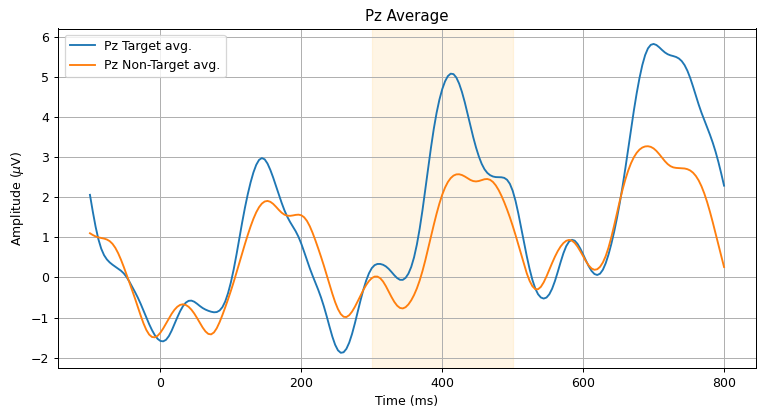

In [28]:
ch_label = 'Pz'
target_avg = np.mean(target, axis=0)
non_target_avg = np.mean(non_target, axis=0)

test_x = [(i*4)-100 for i in range(len(target_avg))]

fig, ax = plt.subplots(figsize = (10, 5), dpi = 90)
ax.axvspan(300, 500, color='orange', alpha=0.1)

ax.plot(test_x, target_avg, label=f'{ch_label} Target avg.')
ax.plot(test_x, non_target_avg, label=f'{ch_label} Non-Target avg.')

ax.set_xlabel('Time (ms)')
ax.set_ylabel(r'Amplitude ($\mu$V)')
ax.set_title(f'{ch_label} Average')
ax.grid(True)
_ = ax.legend()

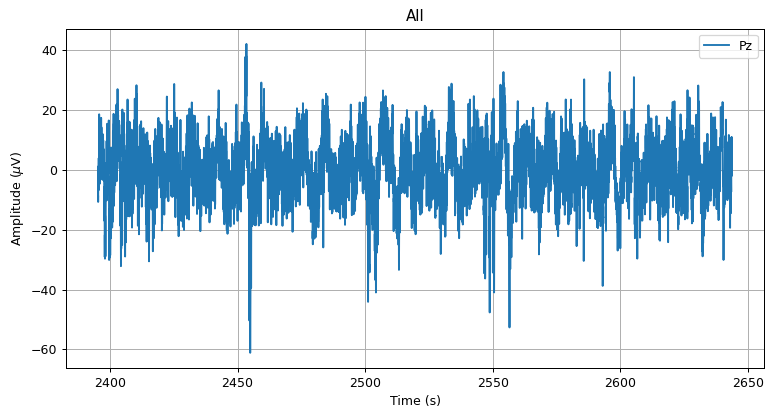

In [29]:
# run_2['time_stamps']

fig, ax = plt.subplots(figsize = (10, 5), dpi = 90)
# ax.axvspan(300, 500, color='orange', alpha=0.1)

filt_data = filter_eeg(run_2['data'], FREQ, freq_range)

for i, val in enumerate(channels):
#     if val == 'ref' or val == 'Fp1':
    if not val == 'Pz':
        continue
    ax.plot(run_2['time_stamps'], filt_data[:,i], label=f'{val}')

ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Amplitude ($\mu$V)')
ax.set_title(f'All')
ax.grid(True)
_ = ax.legend()

In [30]:
# X_Pz_adj
# Y
X_train, X_test, y_train, y_test = train_test_split(X_Pz_adj, Y, test_size=0.5, random_state=32)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('accuracy:', LDA_clf.score(X_test, y_test))

accuracy: 0.8


In [31]:
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
scores = cross_val_score(LDA_clf, X_Pz_adj, Y, cv = 5)
scores

array([0.825     , 0.825     , 0.8       , 0.8       , 0.80833333])

## Online Simulation
Using the first letter runs to train the LDA classifier, then test on the last letter. This can be randomized and performed for each letter.
Probably just using one electrode...Pz

In [36]:
ltr_key = ['ABCDEF',
           'GHIJKL',
           'MNOPQR',
           'STUVWX',
           'YZ1234',
           '56789_']

# rows -> 0-5; cols -> 6-11
def get_letter(row, col):
    col = col - 6
    return ltr_key[row][col]

def predict_run_output(clf, run, channel):
#     {'target': 'P', 'trials': [{'label': 4,
    target = run['target']
    row_match = []
    col_match = []
    confs = np.zeros(shape = (12,1))
    char_mrks = []
    char_conf = []
    for trial in run['trials']:
        lbl = trial['label']
        data = np.array([trial['data'][:,channel]])
#         print('data:', data.shape)
        prediction = clf.predict(data)
        conf = clf.decision_function(data)
#         print(prediction[0], lbl)
        if prediction[0] == 1:
            if lbl < 6:
                row_match.append(lbl)
            else:
                col_match.append(lbl)
                
    
    print(row_match, col_match)
    if not row_match or not col_match:
        print('Not notable events')
        return 'no match'
    
    row_sel = max(row_match, key=row_match.count)
    col_sel = max(col_match, key=col_match.count)
    
    return get_letter(row_sel, col_sel)

def train_clf(clf, all_runs, channel):
    runs_X = []
    runs_y = []
    for run in all_runs:
        target = run['target']
        current_key = answer_key[target]
        for trial in run['trials']:
            x = trial['data'][:, channel]
            runs_X.append(x)
            lbl = trial['label']
            if lbl in current_key:
                runs_y.append(1)
            else:
                runs_y.append(0)
                
    runs_X = np.array(runs_X)
    runs_y = np.array(runs_y)
#     print('runs_X:', runs_X.shape)
    clf = clf.fit(runs_X, runs_y)

    
    return clf

def test_LDA_prediction(all_runs, channel):
#     for run in runs:
    for i, test_run in enumerate(all_runs):
        training_runs = all_runs.copy()
        del training_runs[i]
        
        LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        LDA_clf = train_clf(LDA_clf, training_runs, pz)
        result = predict_run_output(LDA_clf, test_run, pz)
        print(result == test_run['target'])
        print(result, test_run['target'])

In [37]:
test_LDA_prediction(runs, pz)

[-1.2482821]
[-1.98598295]
[-1.68364192]
[-1.45149217]
[-1.43767714]
[-1.04475757]
[-2.07935631]
[-0.71699267]
[-1.25455506]
[-1.53178914]
[-1.26944307]
[-3.06116209]
[-3.10938743]
[-1.62724672]
[-1.12415086]
[-1.70579976]
[-0.82548063]
[-2.09813032]
[-0.64791961]
[-2.4084259]
[-1.81889325]
[-2.32154417]
[-1.53817533]
[-2.79795471]
[-3.24989152]
[-1.17048746]
[-1.12718366]
[-1.25939476]
[-1.17407906]
[-1.39178264]
[-1.81614988]
[-1.64367739]
[-2.07212684]
[-0.62673588]
[-1.43645235]
[-1.67407056]
[-1.44399542]
[-0.77208618]
[-1.33967101]
[-1.07689003]
[-2.49560795]
[-1.72507934]
[0.02171729]
[-1.79530753]
[-2.13950483]
[0.0367404]
[-2.85642694]
[-1.04921946]
[-0.01971597]
[-3.38742531]
[-2.80428579]
[-1.8512261]
[-1.93860041]
[-1.09708175]
[-2.88942212]
[-0.60870859]
[-1.80444459]
[-1.13547794]
[-1.85422066]
[-3.2482174]
[-3.10012782]
[-1.25441454]
[-1.57866611]
[-1.55769848]
[-3.56431172]
[-1.44298516]
[-1.18499126]
[-0.6858683]
[-1.37643688]
[-1.32843419]
[-2.78366345]
[-2.75675656]


In [34]:
import math
chars = [chr(x) for x in range(65,91)]
numbers = list(range(1,10))
space = ['_']

# TODO: clean this up, breaks if there isn't a perfect square root of full_list
full_list = chars + numbers + space
dim = math.ceil(len(full_list)**0.5)
character_grid = np.reshape(full_list, (dim, dim))
character_grid[0]

array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1')

In [35]:
t = [2,3,4,3,5,7,3,7,2]
# np.bincount(t)
max(t, key=t.count)
t.count(2)
t[0:3]+t[4:]

[2, 3, 4, 5, 7, 3, 7, 2]